In [60]:
import keras
import pylab
import numpy as np
keras.__version__

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# 5.1 - Introduction to convnets

This notebook contains the code sample found in Chapter 5, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

First, let's take a practical look at a very simple convnet example. We will use our convnet to classify MNIST digits, a task that you've already been 
through in Chapter 2, using a densely-connected network (our test accuracy then was 97.8%). Even though our convnet will be very basic, its 
accuracy will still blow out of the water that of the densely-connected model from Chapter 2.

The 6 lines of code below show you what a basic convnet looks like. It's a stack of `Conv2D` and `MaxPooling2D` layers. We'll see in a 
minute what they do concretely.
Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)` (not including the batch dimension). 
In our case, we will configure our convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this via 
passing the argument `input_shape=(28, 28, 1)` to our first layer.

In [61]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

<center><h3>Let's display the architecture of our convnet so far:

In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width 
and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to 
the `Conv2D` layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape `(3, 3, 64)`) into a densely-connected classifier network like those you are 
already familiar with: a stack of `Dense` layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. 
So first, we will have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top:

In [63]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network 
looks like:

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                36928     
__________

As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

Now, let's train our convnet on the MNIST digits. We will reuse a lot of the code we have already covered in the MNIST example from Chapter 
2.

In [65]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [66]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=1, batch_size=64, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 42s 881us/step - loss: 0.1972 - acc: 0.9384 - val_loss: 0.0655 - val_acc: 0.9807


<center><h2> We do not have time to train for 100 epochs, so we load one that was trained earlier

In [31]:
from keras.models import load_model
import pickle
model = load_model('../data/models/5-1-GPU.h5')
history_file = open('../data/models/5-1-GPU-history.pk', 'rb')
history_dict = pickle.load(history_file)

In [67]:
# history_dict = model.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [68]:
print('val_loss: {}'.format(history_dict['val_loss'][-1]))
print(' val_acc: {}'.format(history_dict['val_acc'][-1]))
print('    loss: {}'.format(history_dict['loss'][-1]))
print('     acc: {}'.format(history_dict['acc'][-1]))

val_loss: 0.09369472242822588
 val_acc: 0.9921666666666666
    loss: 0.0014198241968023618
     acc: 0.9996666666666667


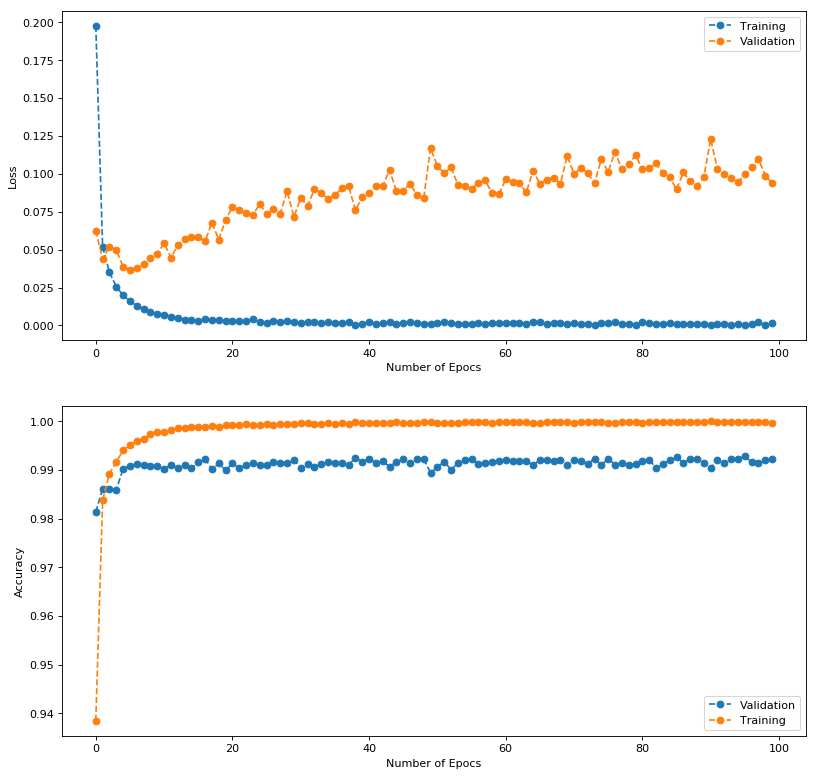

In [69]:
f, (ax1, ax2) = pylab.subplots(2, 1, figsize=(12, 12), dpi= 80)

ax1.plot(history_dict['loss'], 'o--', label='Training')
ax1.plot(history_dict['val_loss'], 'o--', label='Validation')
ax1.set_xlabel('Number of Epocs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(history_dict['val_acc'], 'o--', label='Validation')
ax2.plot(history_dict['acc'], 'o--', label='Training')
ax2.set_xlabel('Number of Epocs')
ax2.set_ylabel('Accuracy')
ax2.legend()

<h3><center>Let's evaluate the model on the test data:

In [70]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 3s 264us/step


In [71]:
pred = model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                36928     
__________

While our densely-connected network from Chapter 2 had a test accuracy of 97.8%, our basic convnet has a test accuracy of 99.3%: we 
decreased our error rate by 68% (relative). Not bad! 

In [74]:
pred = model.predict_classes(train_images)

In [79]:
image_num = 0

In [87]:
valid_class = pred[image_num]

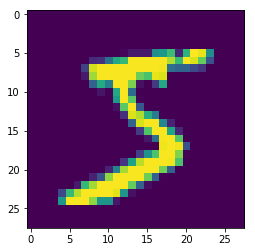

Predicted digit is :: 5

Actual digit is :: [1.]



In [90]:
pylab.imshow(np.squeeze(train_images[0]))
pylab.show()

print("Predicted digit is :: {}".format(valid_class))
print()
print("Actual digit is :: {}".format(number_line[np.asarray(test_labels[valid_class ], dtype=bool)]))
print()

